# Import Libraries

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp

# Data Preparation

## Load Dataset

In [4]:
df = pd.read_csv("Train.csv", index_col="ID")
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,1
2,F,Flight,4,5,216,2,low,M,59,3088,1
3,A,Flight,2,2,183,4,low,M,48,3374,1
4,B,Flight,3,3,176,4,medium,M,10,1177,1
5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [5]:
df.rename(columns={'Reached.on.Time_Y.N': 'Arrived_Late'}, inplace=True)

In [6]:
data = df.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10999 entries, 1 to 10999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Arrived_Late         10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.0+ MB


### Cek Missing Values 

In [8]:
df.isnull().any()

Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Arrived_Late           False
dtype: bool

**Karena pada dataset kita ini tidak ada Missing Values, maka nanti saat tahap Data Pre-Processing, kita tidak perlu Handle Missing Values.**

### Cek Duplicated Data

In [9]:
df.duplicated().any()

False

**Karena pada dataset kita ini tidak ada Data Duplikat, maka nanti saat tahap Data Pre-Processing, kita tidak perlu Handle Duplicated Data.**

## Descriptive Statistics
## Separating Categorical and Numerical Data Types

In [10]:
cats_df = df.select_dtypes(include='object')
nums_df = df.select_dtypes(include='int')

cats = cats_df.columns
nums = nums_df.columns

In [11]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Arrived_Late,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


- Rata-rata Customer care menerima 4.05 panggilan dari seorang customer dan mediannya 4, berdasarkan hal tersebut dapat disimpulkan kolom ini memiliki persebaran normal.

- Customer rating memiliki persebaran yang normal. Rata - rata customer memberikan rating sebesar 3. Ini, menunjukkan bahwa secara umum pelanggan memberikan penilaian yang netral terhadap produk atau layanan yang diterima.

- Cost of the product memiliki rata - rata dan median yang tidak berbeda jauh, yaitu 210.2 usd dan 214 usd. Hal ini berindikasi bahwa harga produk memiliki persebaran yang cenderung normal. Harga produk termurah adalah 96 usd, sedangkan yang termahal berharga 310 usd.

- Sekitar 25% customers sudah melakukan pembelian setidaknya 3 kali. Ini menunjukkan adanya basis pelanggan yang setia dan kemungkinan adanya peluang untuk meningkatkan loyalitas pelanggan.

- Rata-rata discount yang ditawarkan sekitar 13% dan mediannya 7%. Perbedaan nilai mean dan median yang cukup signifikan tersebut mengindikasikan distribusi positively skewed. Menurut tim kami, hal ini normal karena jika diskon besar yang ditawarkan terlalu banyak akan mengurangi profit dari perusahaan. Diskon terendah yang ditawarkan adalah 1% dan terbesarnya 65%. Selain itu, strategi diskon yang bervariasi dan cenderung rendah dapat digunakan untuk menarik pelanggan tanpa mengorbankan profitabilitas perusahaan.

- Weight in gms (berat produk) memiliki perbedaan rata-rata dan median yang sangat besar, dengan meannya 3634 gram dan mediannya 4149 gram. Dapat dipastikan kolom ini memiliki distribusi skewed. Berat minimum suatu produk ialah 1001 gram dan berat maksimum suatu produk 7846 gram.

- Kolom Arrived_Late (kolom target kita) memiliki perbedaan jumlah data yang relatif kecil jika dibandingkan dengan jumlah keseluruhan data yang kita miliki, sedikit tidak seimbang.

### Checking Negative Values for Numerical Data Types

In [12]:
# cek data rows yang negatif apakah ada
negative = (df.select_dtypes(include=['int64','float64']) < 0 ).any(axis=1)


# Menampilkan indeks atau baris yang berisi nilai negatif
if negative.any():
    print("Baris dengan nilai negatif:")
    print(df[negative].index)
else:
    print("Tidak ada baris dengan nilai negatif")

Tidak ada baris dengan nilai negatif


**Data-data numerik pada dataset ini valid dan tidak ada yang aneh karena tidak ditemukan data negatif.**

### Checking Value Count Categorical

In [13]:
df[cats].describe().T

,count,unique,top,freq
Warehouse_block,10999,5,F,3666
Mode_of_Shipment,10999,3,Ship,7462
Product_importance,10999,3,low,5297
Gender,10999,2,F,5545


In [14]:
# check value count data kategorik
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

print('Value count kolom Arrived_Late:')
print(df['Arrived_Late'].value_counts())

Value count kolom Warehouse_block:
Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

Value count kolom Mode_of_Shipment:
Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

Value count kolom Product_importance:
Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64

Value count kolom Gender:
Gender
F    5545
M    5454
Name: count, dtype: int64

Value count kolom Arrived_Late:
Arrived_Late
1    6563
0    4436
Name: count, dtype: int64


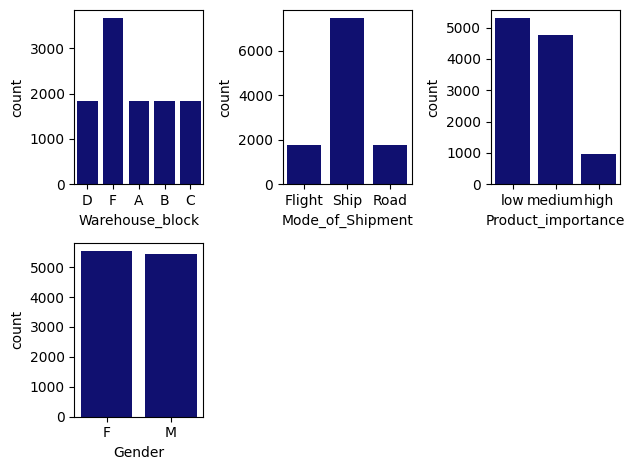

In [15]:
# visualization categorical variable
for i in range(0, len(cats)):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df, x=cats[i], color='navy', orient='h')
    plt.tight_layout()

- Pada kolom Warehouse_block, kategori F memiliki frekuensi tertinggi sebesar 3666 dan perbedaan dengan warehouse lain cukup signifikan, hal ini membuat ketimpangan data dan bisa menyebabkan kekurangan stock dan membebani gudang untuk penyediaan alokasi barang sesuai antrian.

- Kolom Mode_of_Shipment pun mengalami ketimpangan data paling tinggi sebesar 7462, dimana Produk yang dikirim dengan Ship jauh lebih banyak dibanding dua mode pengiriman lainnya. Kemungkinan akan terjadi keterlambatan karena antrian panjang yang tidak efisien. Ship lebih banyak di pilih karena ekonomis atau lebih cocok untuk barang-barang besar dan berat elektronik.

- Di kolom Product_importance, kategori Low dan Medium memiliki data yang cukup berimbang, masing-masing sebesar 5297 dan 4754. Namun, kategori High sangatlah sedikit. Menurut kami, hal ini wajar karena mungkin customer lebih memilih untuk bertransaksi secara langsung daripada bertransaksi online jika barang yang diinginkan sangat penting nilainya. Product low lebih banyak karena lebih terjangkau atau lebih banyaknya pilihan dalam kategorinya, sehingga permintaannya banyak.

- Value pada kolom gender seimbang yaitu F (5545) dan M (5454), ada indikasi bahwa pembelian produk sangat universal, preferensi produk yang ditawarkan relevan untuk gender Female dan Male, serta segmentasi pasarnya memang menargetkan ke dua gender.

# Exploratory Data Analysis and Visualization

## Univariate Analysis

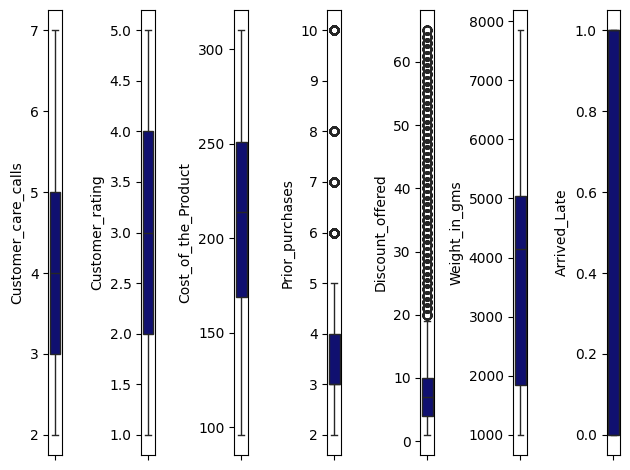

In [16]:
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=df[nums[i]], color='navy', orient='v')
    plt.tight_layout()

Customer care calls, customer rating, cost of the product, dan Weight in gms tidak ada outlier

**Terdeteksi outlier pada feature Discount offered dan Prior purchase**, namun kami mungkin tidak akan menangani outlier tersebut karena pertimbangan berikut:

* Outlier yang ada di kolom diskon ini masih masuk akal. Data-data tersebut menjadi outlier mungkin karena memang jumlah datanya cenderung lebih sedikit dibandingkan dengan yang lain. Hal tersebut wajar saja, karena company pastinya tidak memberikan sebanyak mungkin sebanyak-banyaknya. Pemberian diskon yang lebih tinggi mungkin lebih diprioritaskan kepada pelanggan yang telah lama berlangganan.
* Outlier di kolom Prior Purchases pun masih wajar. Beberapa customer yang beli sampai sebanyak itu mungkin memang sudah begitu percaya pada e-commerce company tersebut.

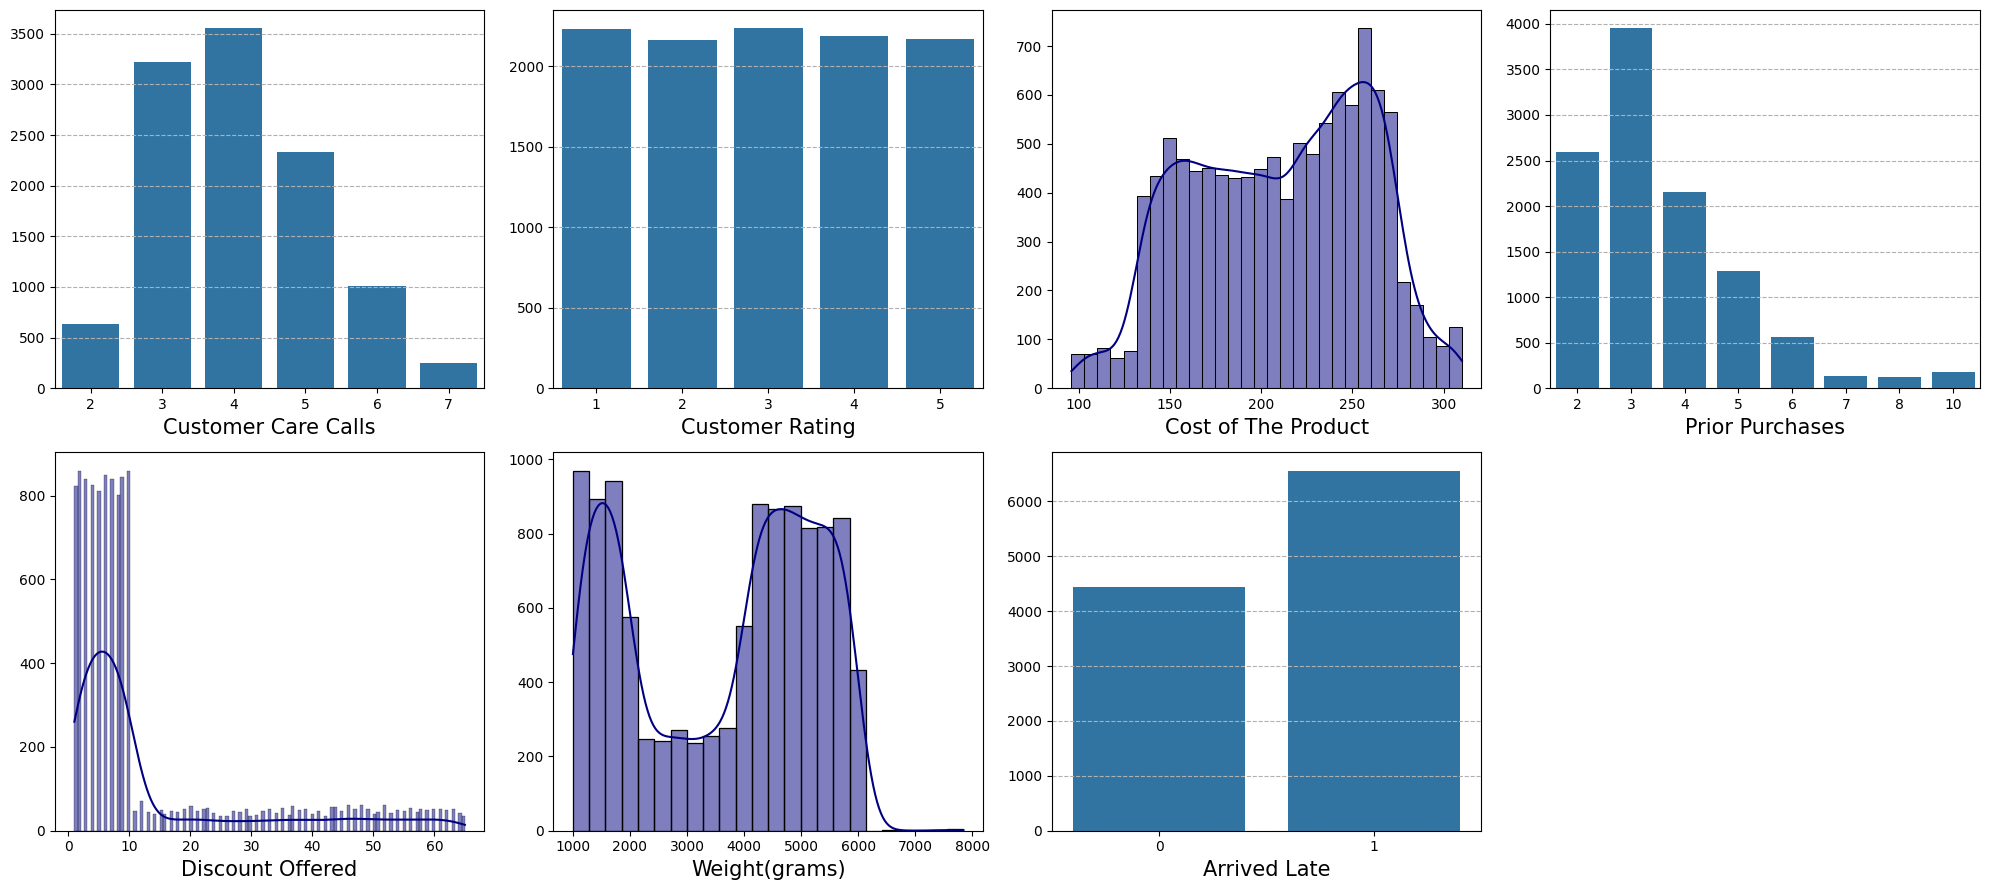

In [17]:
fig, axs = plt.subplots(2, 4,figsize=(20, 9))

sns.countplot(x = 'Customer_care_calls', data=df, ax=axs[0, 0])
axs[0, 0].grid(axis='y', linestyle='--')
axs[0, 0].set_xlabel('Customer Care Calls', fontsize=15)
axs[0, 0].set_ylabel('')

sns.countplot(x = 'Customer_rating', data=df, ax=axs[0, 1])
axs[0, 1].grid(axis='y', linestyle='--')
axs[0, 1].set_xlabel('Customer Rating', fontsize=15)
axs[0, 1].set_ylabel('')

sns.histplot(x = 'Cost_of_the_Product', data=df, ax=axs[0, 2], color='navy', kde=True)
axs[0, 2].set_xlabel('Cost of The Product', fontsize=15)
axs[0, 2].set_ylabel('')

sns.countplot(x = 'Prior_purchases', data=df, ax=axs[0, 3])
axs[0, 3].grid(axis='y', linestyle='--')
axs[0, 3].set_xlabel('Prior Purchases', fontsize=15)
axs[0, 3].set_ylabel('')

sns.histplot(x = 'Discount_offered', data=df, ax=axs[1, 0], color='navy', kde=True)
axs[1, 0].set_xlabel('Discount Offered', fontsize=15)
axs[1, 0].set_ylabel('')

sns.histplot(x = 'Weight_in_gms', data=df, ax=axs[1, 1], color='navy', kde=True)
axs[1, 1].set_xlabel('Weight(grams)', fontsize=15)
axs[1, 1].set_ylabel('')

sns.countplot(x = 'Arrived_Late', data=df, ax=axs[1, 2])
axs[1, 2].grid(axis='y', linestyle='--')
axs[1, 2].set_xlabel('Arrived Late', fontsize=15)
axs[1, 2].set_ylabel('')

axs[1, 3].axis('off')

plt.tight_layout()
plt.show();

- Customer_care_calls memiliki persebaran data yang cukup normal. Dengan menerima jumlah panggilan sebanyak 3-4 kali calls. Hal ini, mengindikasikan tingkat kepercayaan customer terhadap pelayanan pengiriman masih tergolong rendah. Perlunya peningkatan pelayanan pengiriman agar tepat waktu sehingga jumlah panggilan menjadi turun di 1-2 kali.

- Customer rating sangat balance, mengindikasikan pelayanan masih belum begitu memberikan dampak pada rating. 

- Data Cost_of_the_Product memiliki distribusi bimodal. Lonjakan biaya pada produk terjadi 2 kali, yaitu berkisar antara 180 - 250. Perlunya peningkatan control agar cost_of_product dapat lebih stabil.

- Persebaran data pada kolom Prior_purchases, grafiknya mengindikasikan kebanyakan customer baru melakukan pembelian sekitar 2-4 kali. Maka dari itu, kolom ini berisiko memiliki outlier atas. Untuk analisis lebih lanjut, lebih baik kita gunakan median dan IQR daripada mean dan standard deviation.

- Persebaran data pada kolom Discount_offered. Dapat kita lihat, bahwa sedikit sekali yang mendapatkan diskon di atas 20%. Hal tersebut normal saja karena mungkin hanya customer-customer tertentu saja yang mendapatkan penawaran diskon sebesar itu. Sama seperti kolom Prior_purchases, untuk analisis lebih lanjut, lebih baik kita gunakan median dan IQR daripada mean dan standard deviation.

- Kolom Weight_in_gms (Berat) memiliki distribusi bimodal. Terlihat pada grafik bahwa jumlah barang didominasi oleh product berukuran +-1000 gms dan +-5000 gms, dari sini bisa ditentukan prioritas mode of shipment agar pengiriman product lebih cepat dan effisien.

- Arrived_Late adalah kolom target, kolom ini merupakan data categorical yang sudah di-encode. Jadi, sebenarnya grafik di atas tidak memberikan insight yang begitu berarti. Namun, kita dapat melihat bahwa datanya imbalance, tepat waktu (0) dan tidak tepat waktu sedikit lebih banyak (1).

## Multivariate Analysis

<Axes: >

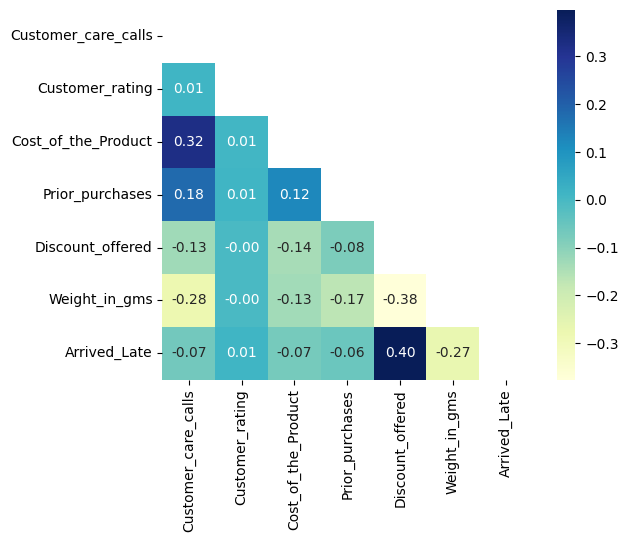

In [18]:
corr_matrix = df[nums].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, annot=True,mask=mask, cmap="YlGnBu", fmt='.2f',square=True)

- Tidak ada korelasi yang kuat antara fitur-fitur dan keterlambatan pengiriman (“Arrived_Late”). Korelasi tertinggi terjadi antara Discount offered dan Arrived_Late dengan nilai 0.40 artinya semakin besar diskon yang ditawarkan maka semakin besar kemungkinan delivery-nya terlambat.
- Selain itu terdapat korelasi negatif yang relatif tinggi antara “Weight_in_gms” dan “Arrived_Late” dengan nilai -0.27, ini menunjukkan korelasi negatif yang lemah. Sehingga semakin berat paketnya, kemungkinan untuk sampai terlambat semakin kecil.
- Terdapat korelasi yang relatif tinggi antara "Cost_of_the_product" dan "Customer_care_calls" artinya semakin besar cost of the product kemungkinan semakin besar juga customer calls yang diterima..
- Customer ratings tidak memiliki korelasi dengan discount_offered dan weight_in_gms.
- Prior purchase dan Customer care calls dengan nilai 0.18, ini memiliki korelasi positif yang lemah, artinya ketika terjadi repeat pembelian, semakin banyak Customer care menerima banyak panggilan.

<Figure size 1500x1500 with 0 Axes>

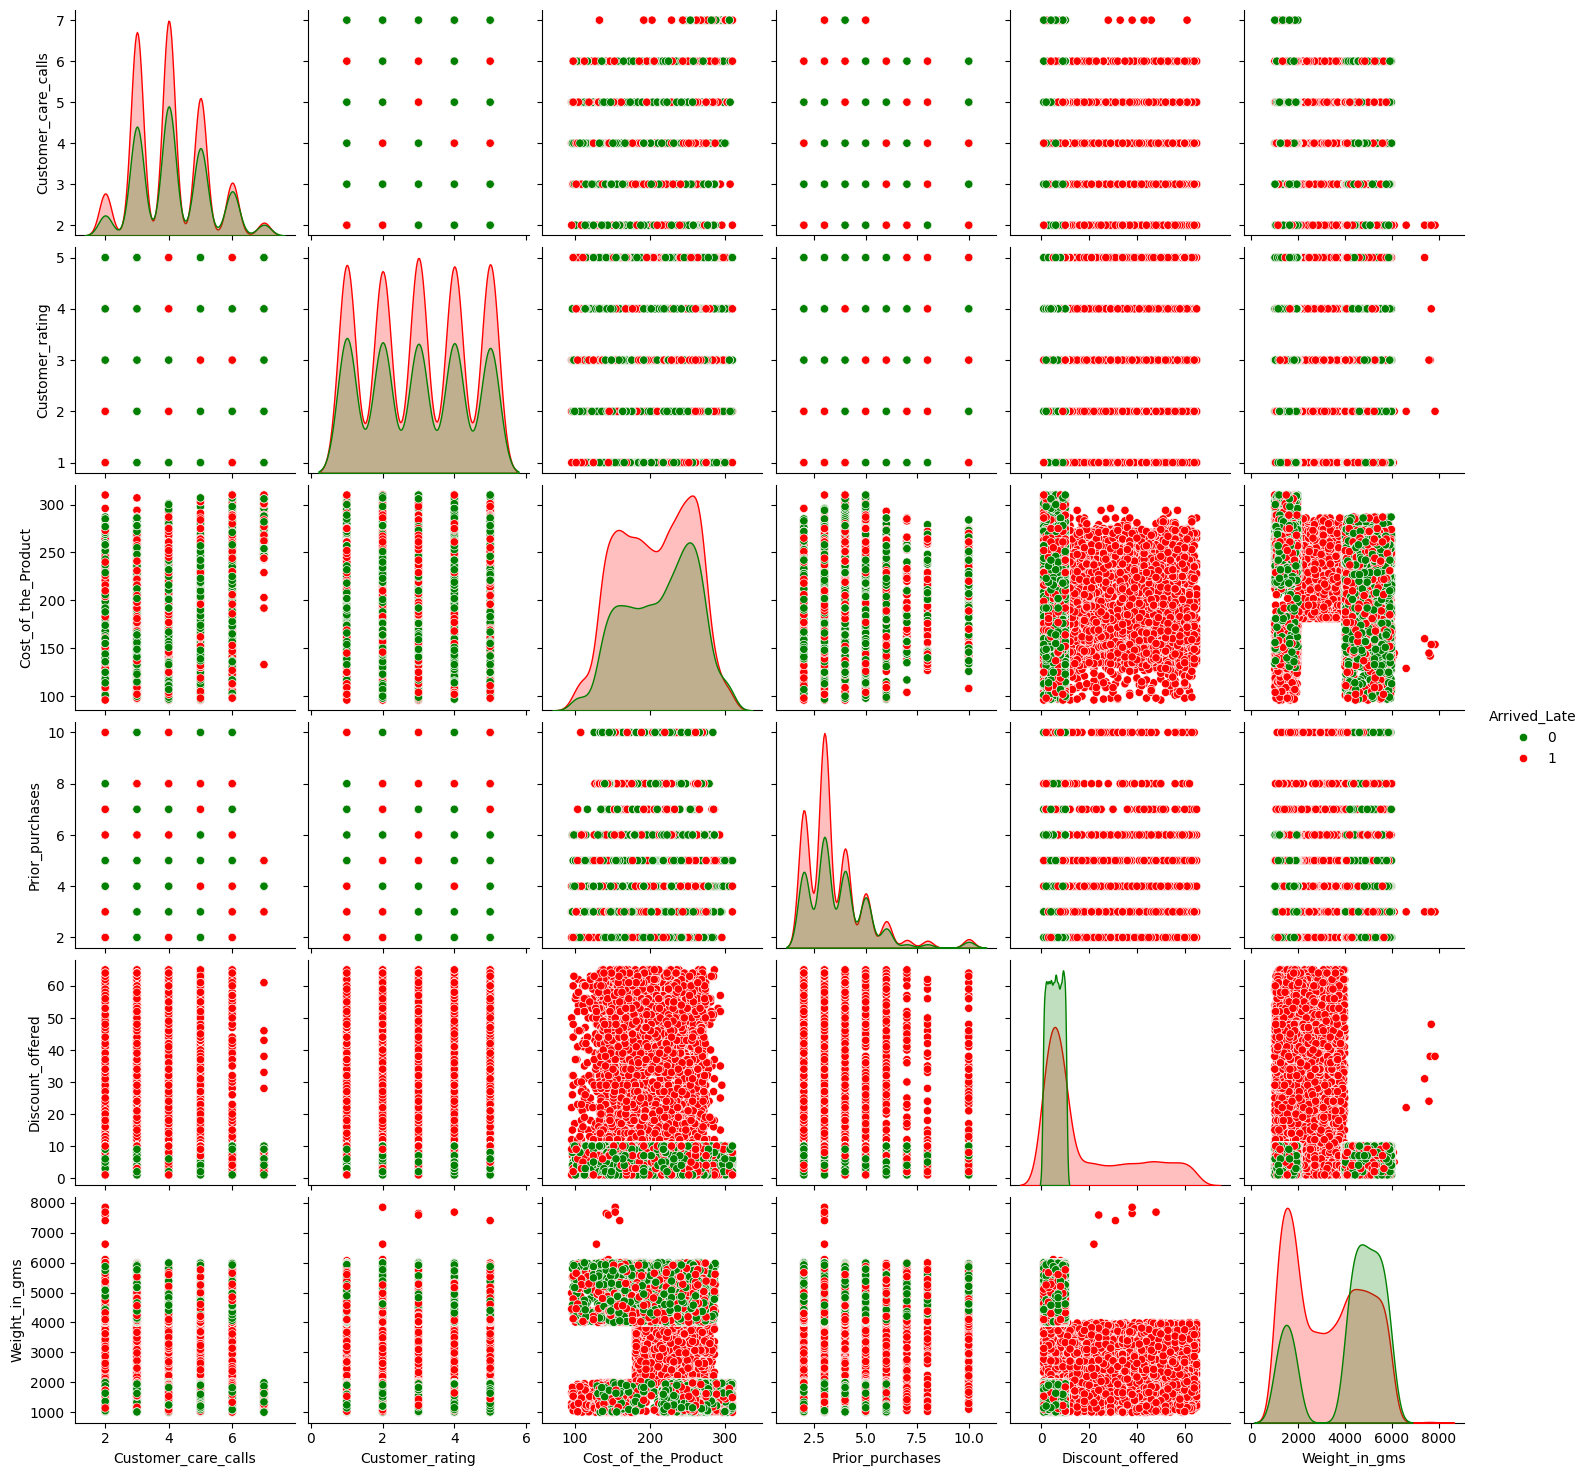

In [19]:
plt.figure(figsize=(15, 15))
sns.pairplot(df, diag_kind='kde', hue='Arrived_Late', palette={0:'g', 1:'r'})

Persebaran fitur-fitur dengan target variabel (Arrived_Late) cenderung tidak berpola pasti, tapi ada beberapa pola yang unik

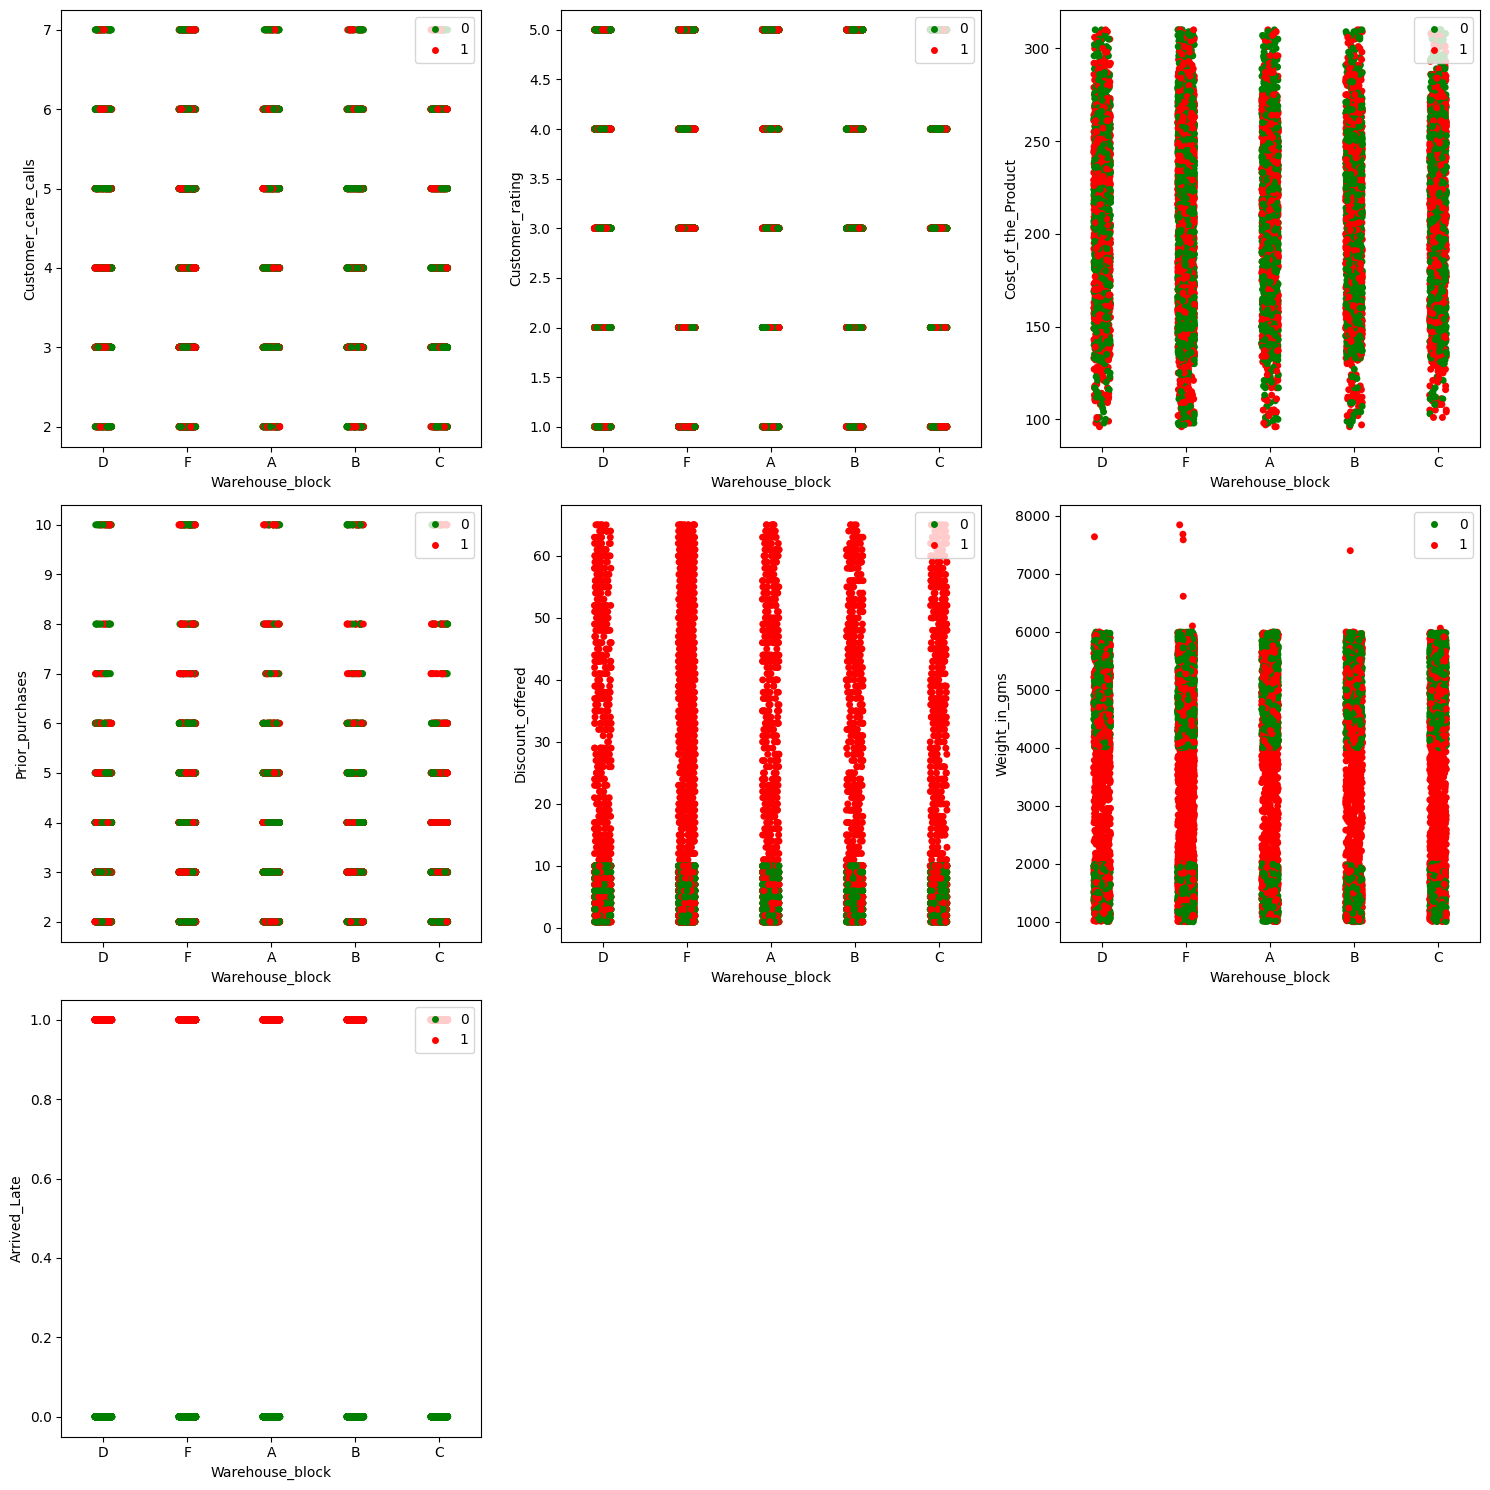

In [20]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(nums)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df, x='Warehouse_block', y=nums[i], hue='Arrived_Late', palette={0:'g', 1:'r'}) # gambar catplot/stripplotnya
    plt.legend(loc='upper right')
    plt.tight_layout()

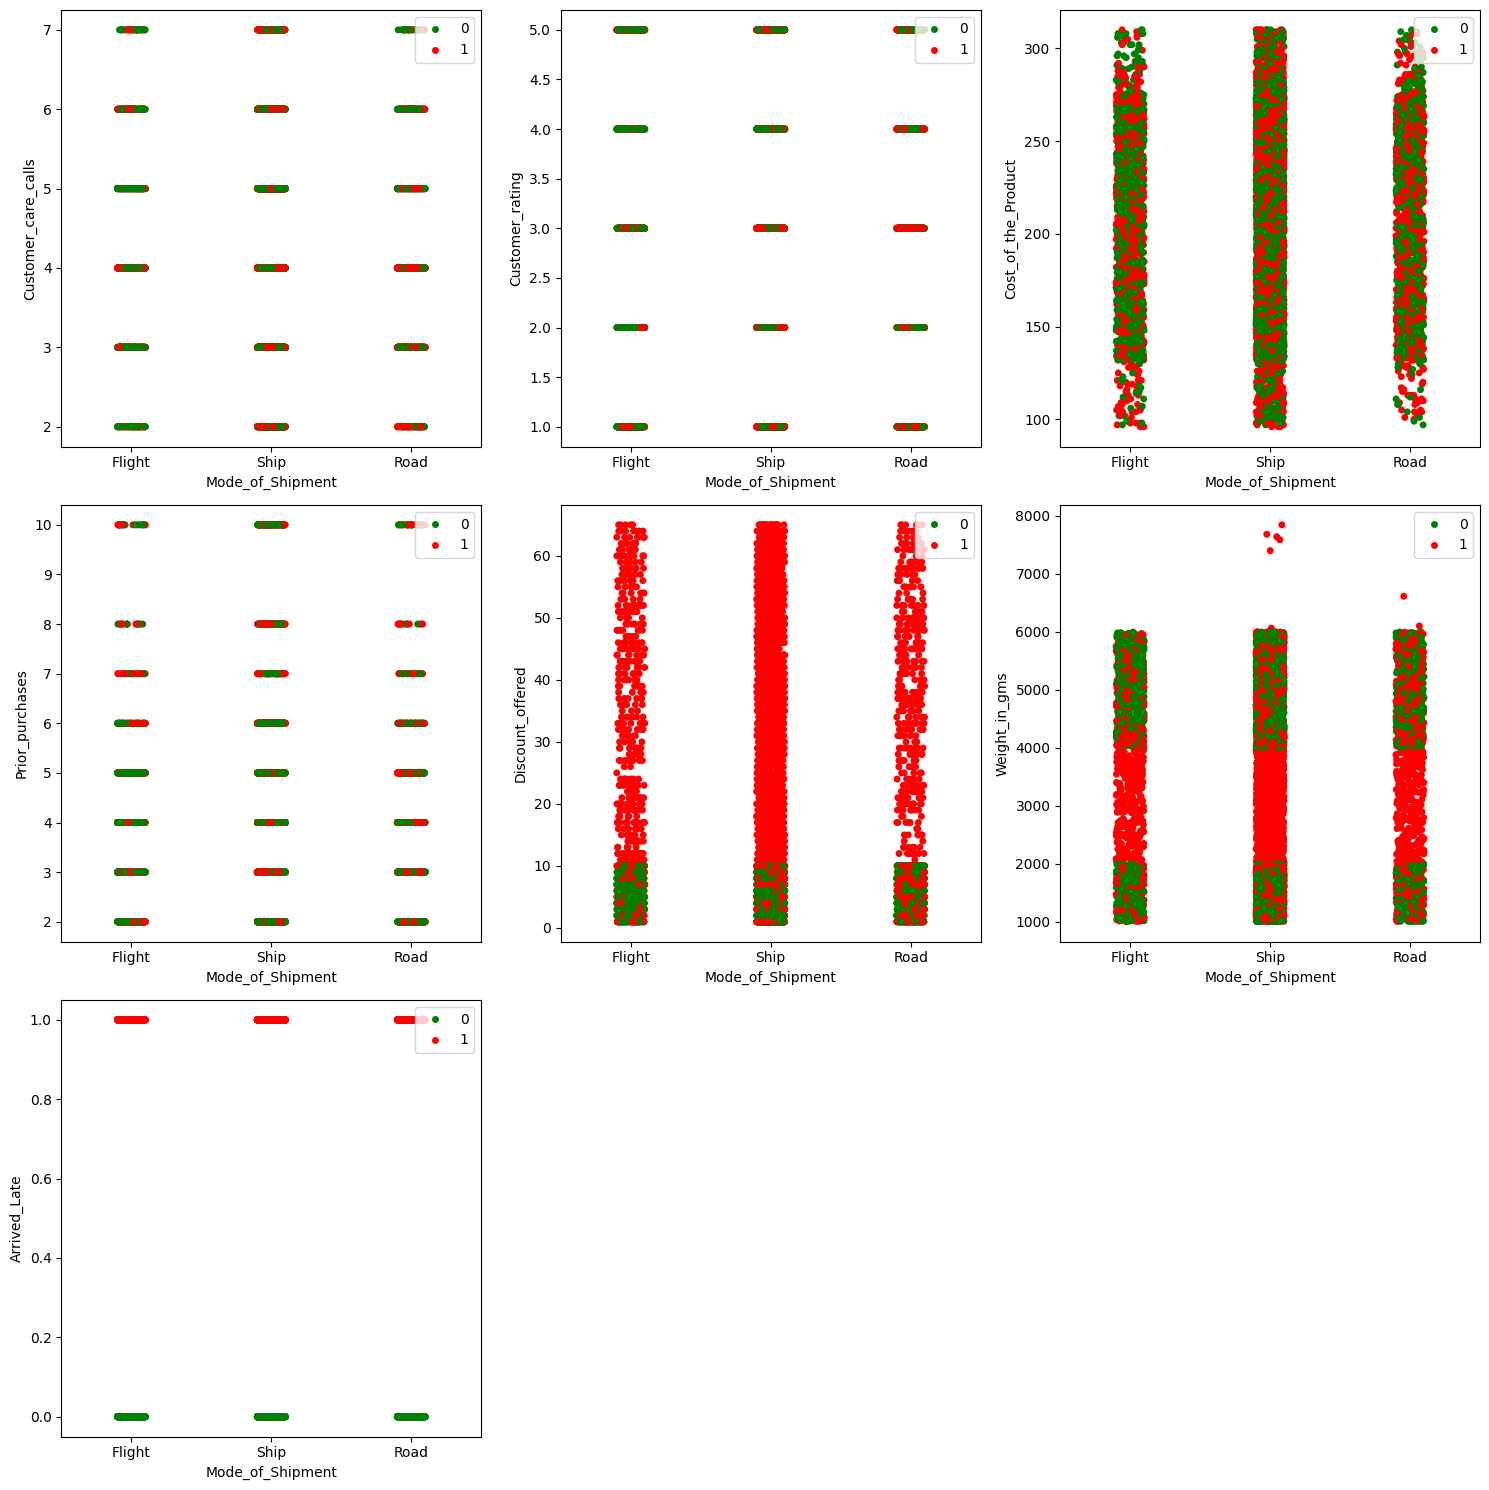

In [21]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(nums)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df, x='Mode_of_Shipment', y=nums[i], hue='Arrived_Late', palette={0:'g', 1:'r'}) # gambar catplot/stripplotnya
    plt.legend(loc='upper right')
    plt.tight_layout()

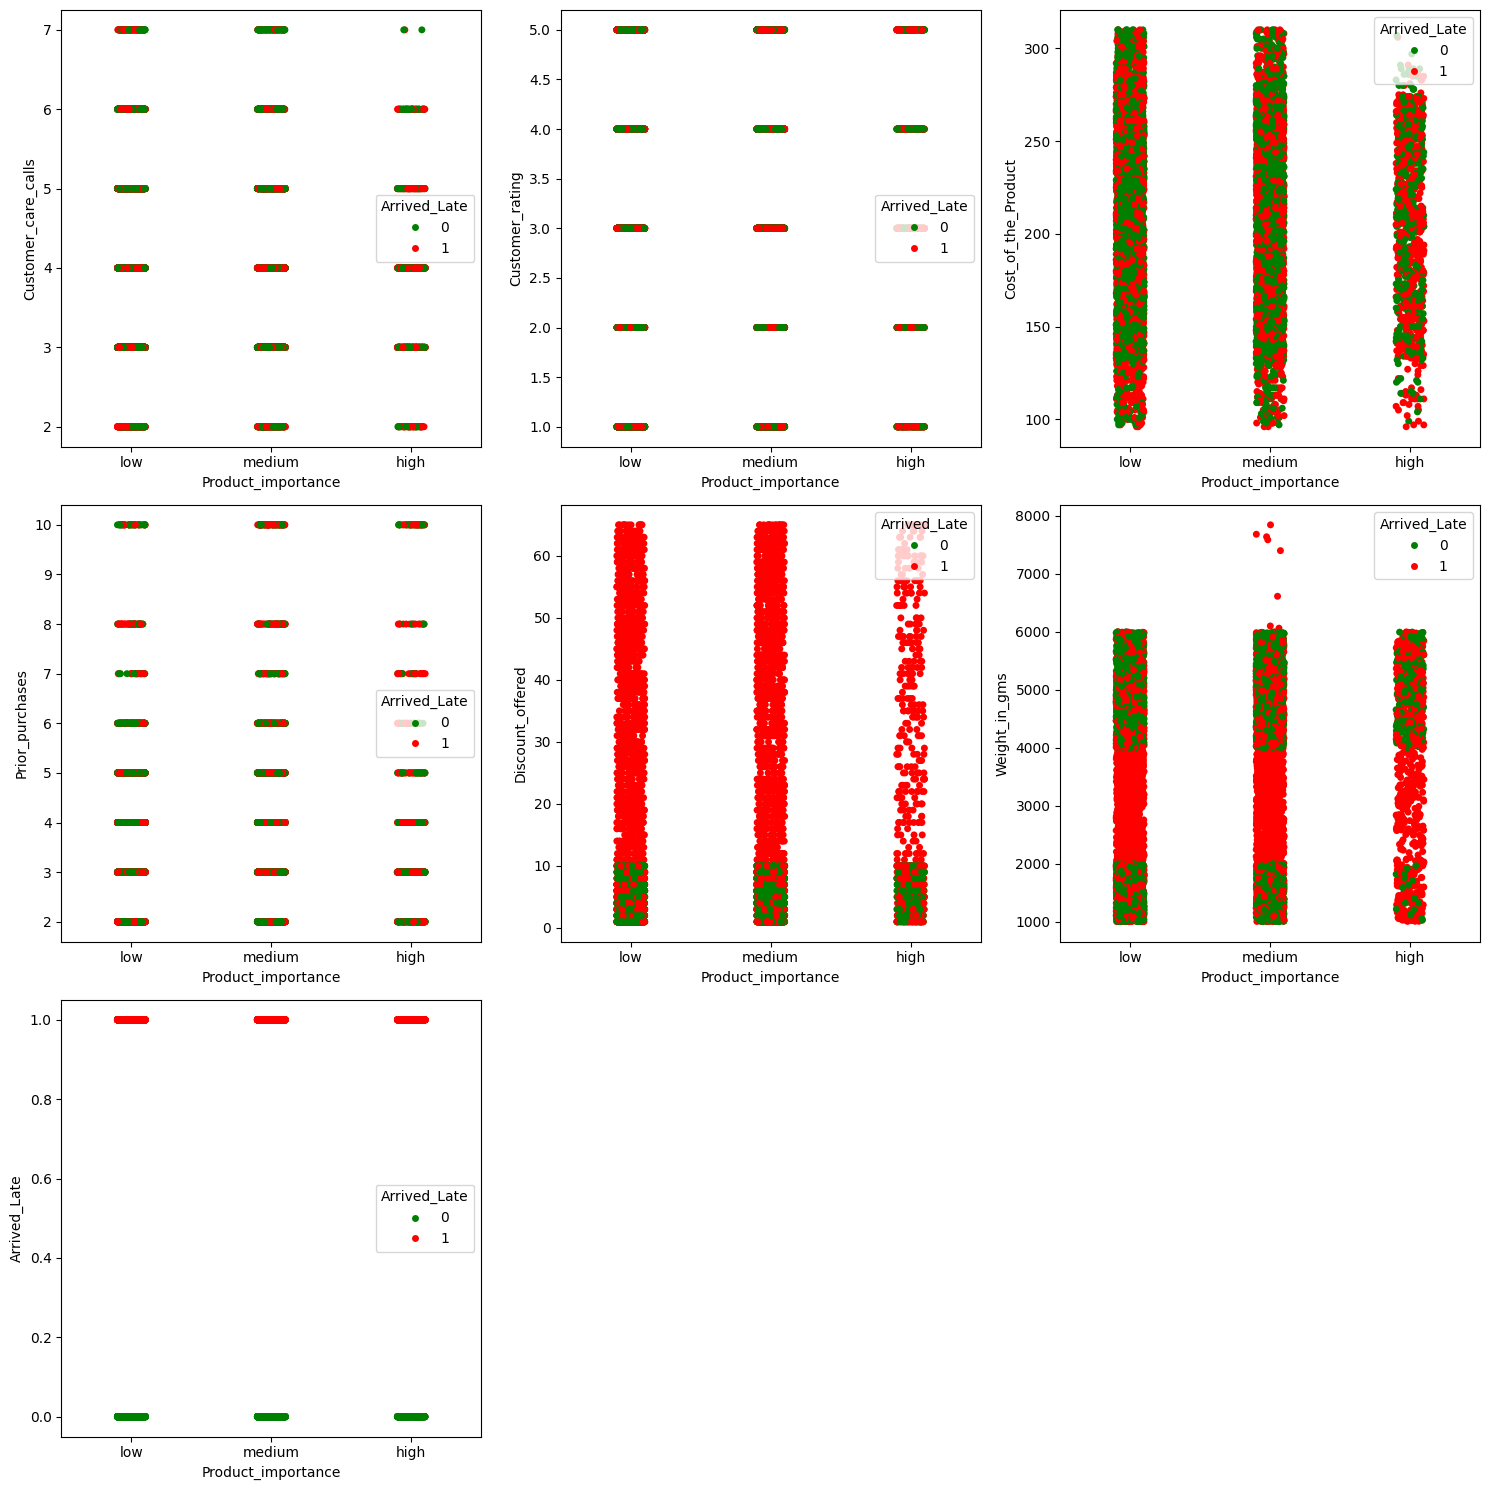

In [22]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(nums)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df, x='Product_importance', y=nums[i], hue='Arrived_Late', palette={0:'g', 1:'r'}) # gambar catplot/stripplotnya
    plt.tight_layout()

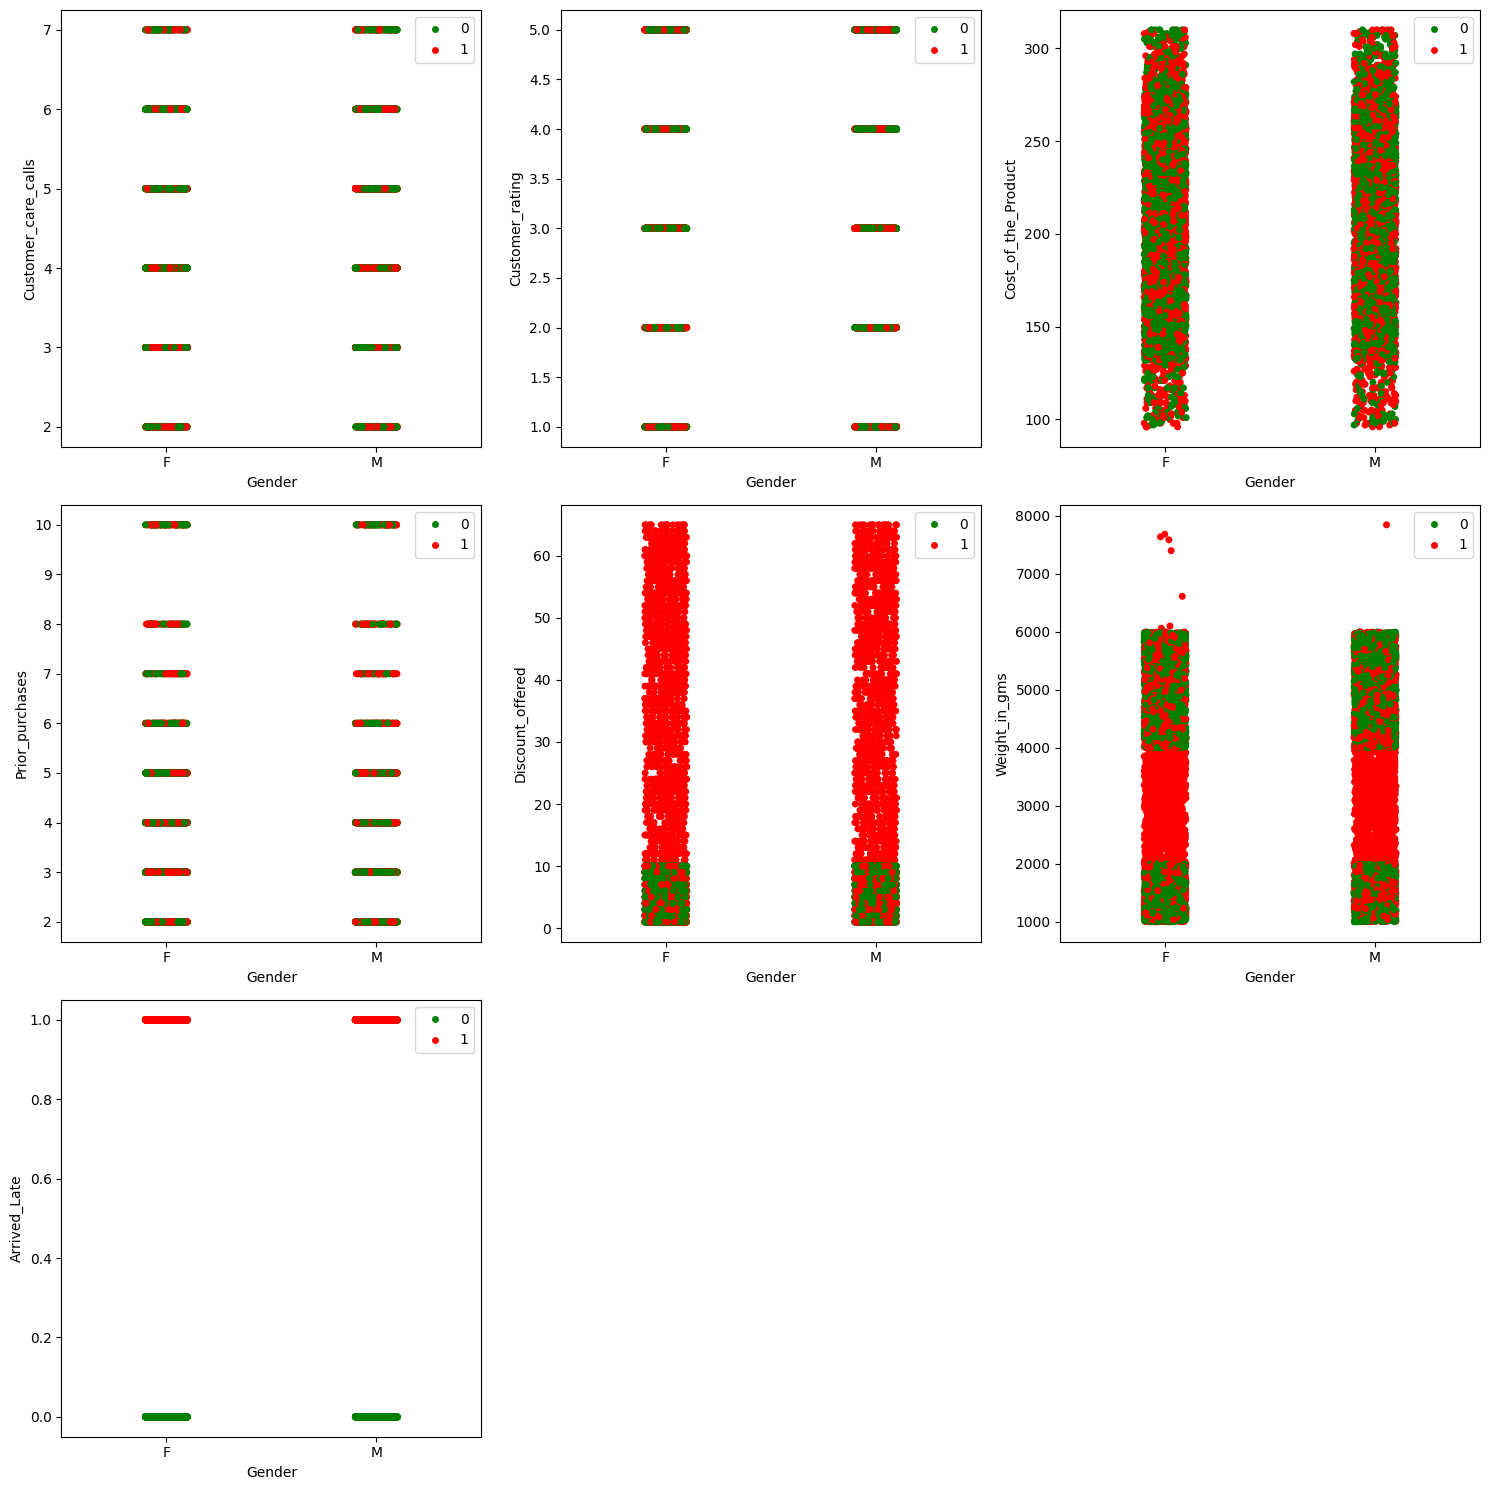

In [23]:
fig = plt.figure(figsize=(15, 15))
for i in range(0, len(nums)): # untuk setiap kolom numerik
    ax = fig.add_subplot(3, 3, i+1) # kita set posisi catplot/stripplotnya di layout
    sns.stripplot(ax=ax, data=df, x='Gender', y=nums[i], hue='Arrived_Late', palette={0:'g', 1:'r'}) # gambar catplot/stripplotnya
    plt.legend(loc='upper right')
    plt.tight_layout()

C:\Users\mufad\AppData\Local\Temp\ipykernel_27544\1382471407.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_discount_offered = df.groupby('Discount_offered_bins')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
C:\Users\mufad\AppData\Local\Temp\ipykernel_27544\1382471407.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  normalized_discount_offered = normalized_discount_offered.pivot_table(values='Percentage', columns='Arrived_Late', index='Discount_offered')
C:\Users\mufad\AppData\Local\Temp\ipykernel_27544\1382471407.py:11: FutureWarning: The default of observed=False is deprecated and will be chan

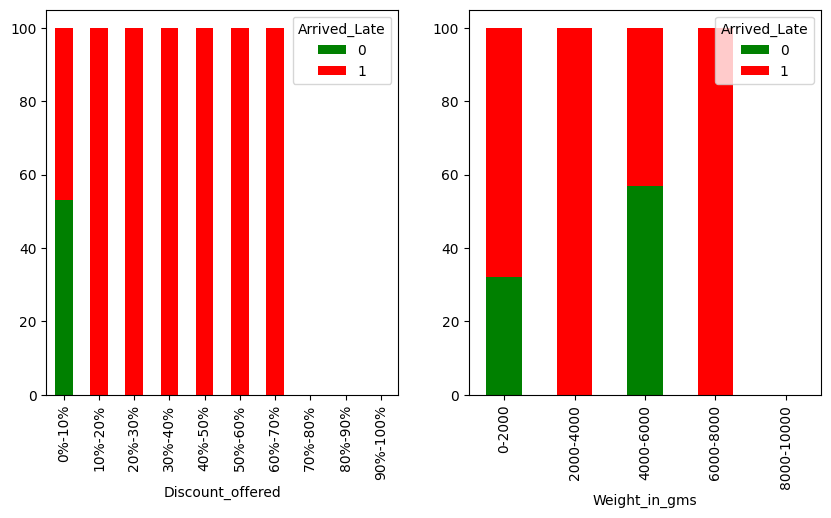

In [24]:
df['Discount_offered_bins'] = pd.cut(df['Discount_offered'], bins=np.arange(0, 101, 10), labels=['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%'])
df['Weight_bins'] = pd.cut(df['Weight_in_gms'], bins=np.arange(0, 10001, 2000), labels=['0-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000'])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

normalized_discount_offered = df.groupby('Discount_offered_bins')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_discount_offered.columns = ['Discount_offered', 'Arrived_Late', 'Percentage']
normalized_discount_offered = normalized_discount_offered.pivot_table(values='Percentage', columns='Arrived_Late', index='Discount_offered')
normalized_discount_offered.plot(kind='bar', stacked=True, ax=axs[0], color=['green', 'red'])

normalized_weight = df.groupby('Weight_bins')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_weight.columns = ['Weight_in_gms', 'Arrived_Late', 'Percentage']
normalized_weight = normalized_weight.pivot_table(values='Percentage', columns='Arrived_Late', index='Weight_in_gms')
normalized_weight.plot(kind='bar', stacked=True, ax=axs[1], color=['green', 'red'])

plt.show()

- Product yang mendapatkan diskon lebih dari 10 % tidak ada yang sampai tepat waktu. Mungkin hal ini terjadi, karena tidak begitu banyak event yang memberikan discount sehingga volume pesanan masih dalam batas wajar.
- Berdasarkan hasil analisis kami, ada hal unik yang terdapat pada kolom berat. Dimana product dengan berat di dalam range 2000-4000 gram tidak ada yang sampai tepat waktu.

Kedua insight unik yang kami dapatkan ini akan menjadi landasan bagi kami saat melakukan proses lanjutan nanti, contohnya adalah **proses Feature Engineering.** Kami akan membuat dua kolom baru, yaitu **weight_between_2kg_and_4kg** dan **is_discount_>10%**. 

In [25]:
df[(df['Weight_in_gms']>2000) & (df['Weight_in_gms']<4000) & (df['Arrived_Late']==0)]

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Arrived_Late,Discount_offered_bins,Weight_bins
ID,,,,,,,,,,,,,


Berdasarkan tabel di atas, terlihat bahwa produk dengan berat 2000 - 4000 tidak ada yang mencapai tepat waktu

In [26]:
df[(df['Discount_offered']>10) & (df['Arrived_Late']==0)]

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Arrived_Late,Discount_offered_bins,Weight_bins
ID,,,,,,,,,,,,,


Berdasarkan tabel di atas, dengan discount >10 tidak ada produk yang mencapai tepat waktu atau mengalami keterlambatan

## Numerical vs Target Proportion

C:\Users\mufad\AppData\Local\Temp\ipykernel_27544\3772791562.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_cost = df.groupby('Cost_of_the_product_bins')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
C:\Users\mufad\AppData\Local\Temp\ipykernel_27544\3772791562.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  normalized_cost = normalized_cost.pivot_table(values='Percentage', columns='Arrived_Late', index='Cost_of_the_product')


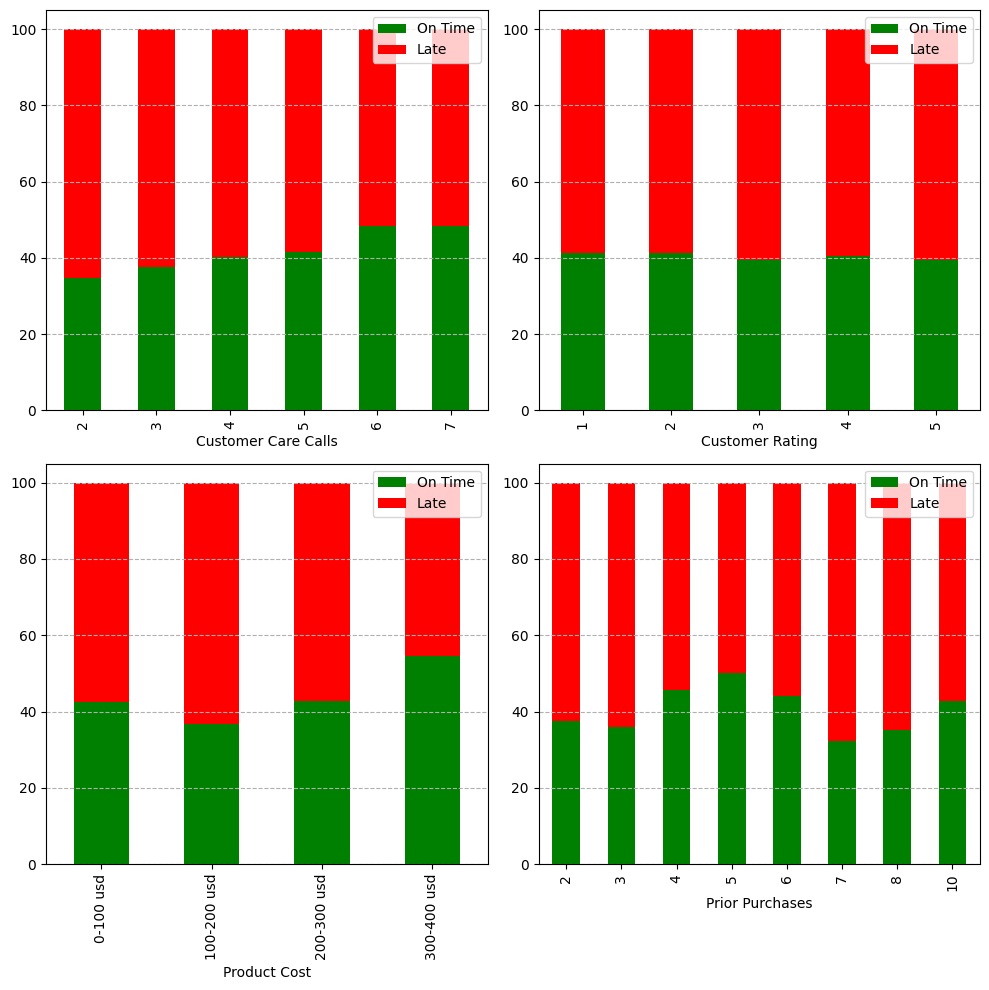

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

normalized_ccc = df.groupby('Customer_care_calls')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_ccc.columns = ['Customer_care_calls', 'Arrived_Late', 'Percentage']
normalized_ccc = normalized_ccc.pivot_table(values='Percentage', columns='Arrived_Late', index='Customer_care_calls')
normalized_ccc.plot(kind='bar', stacked=True, ax=axs[0, 0], color=['green', 'red'])
axs[0, 0].set_xlabel('Customer Care Calls')

normalized_cr = df.groupby('Customer_rating')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_cr.columns = ['Customer_rating', 'Arrived_Late', 'Percentage']
normalized_cr = normalized_cr.pivot_table(values='Percentage', columns='Arrived_Late', index='Customer_rating')
normalized_cr.plot(kind='bar', stacked=True, ax=axs[0, 1], color=['green', 'red'])
axs[0, 1].set_xlabel('Customer Rating')

df['Cost_of_the_product_bins'] = pd.cut(df['Cost_of_the_Product'], bins=np.arange(0, 401, 100), labels=['0-100 usd', '100-200 usd', '200-300 usd', '300-400 usd'])
normalized_cost = df.groupby('Cost_of_the_product_bins')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_cost.columns = ['Cost_of_the_product', 'Arrived_Late', 'Percentage']
normalized_cost = normalized_cost.pivot_table(values='Percentage', columns='Arrived_Late', index='Cost_of_the_product')
normalized_cost.plot(kind='bar', stacked=True, ax=axs[1, 0], color=['green', 'red'])
axs[1, 0].set_xlabel('Product Cost')

normalized_pp = df.groupby('Prior_purchases')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_pp.columns = ['Prior_purchases', 'Arrived_Late', 'Percentage']
normalized_pp = normalized_pp.pivot_table(values='Percentage', columns='Arrived_Late', index='Prior_purchases')
normalized_pp.plot(kind='bar', stacked=True, ax=axs[1, 1], color=['green', 'red'])
axs[1, 1].set_xlabel('Prior Purchases')

for a in range(0, 2):
    for b in range(0, 2):
        axs[a, b].grid(axis='y', linestyle='--')
        axs[a, b].legend(['On Time', 'Late'], loc='upper right')

plt.tight_layout()
plt.show()

- Keterlambatan terjadi pada semua jumlah panggilan customer care. 
Namun seiring meningkatnya jumlah panggilan, terjadi peningkatan sedikit demi sedikit juga pada persentase ketepatan waktunya. Ada indikasi ketika ada penawaran diskon menarik, pelanggan memiliki ekspektasi yang lebih tinggi terhadap pengiriman produk yang diskon, dan jika terjadi keterlambatan, mereka lebih cenderung untuk menghubungi Customer Care.

- Semakin mahal harga suatu product, semakin besar juga kemungkinan product itu sampai tepat waktu. Ini bisa disebabkan oleh pengelolaan prioritas pengiriman, di mana produk dengan harga yang lebih tinggi, mungkin mendapatkan perhatian lebih besar dalam hal pengiriman tepat waktu.

- Prior purchases mengalami keterlambatan yang fluktuatif.

## Categorical vs Target Proportion

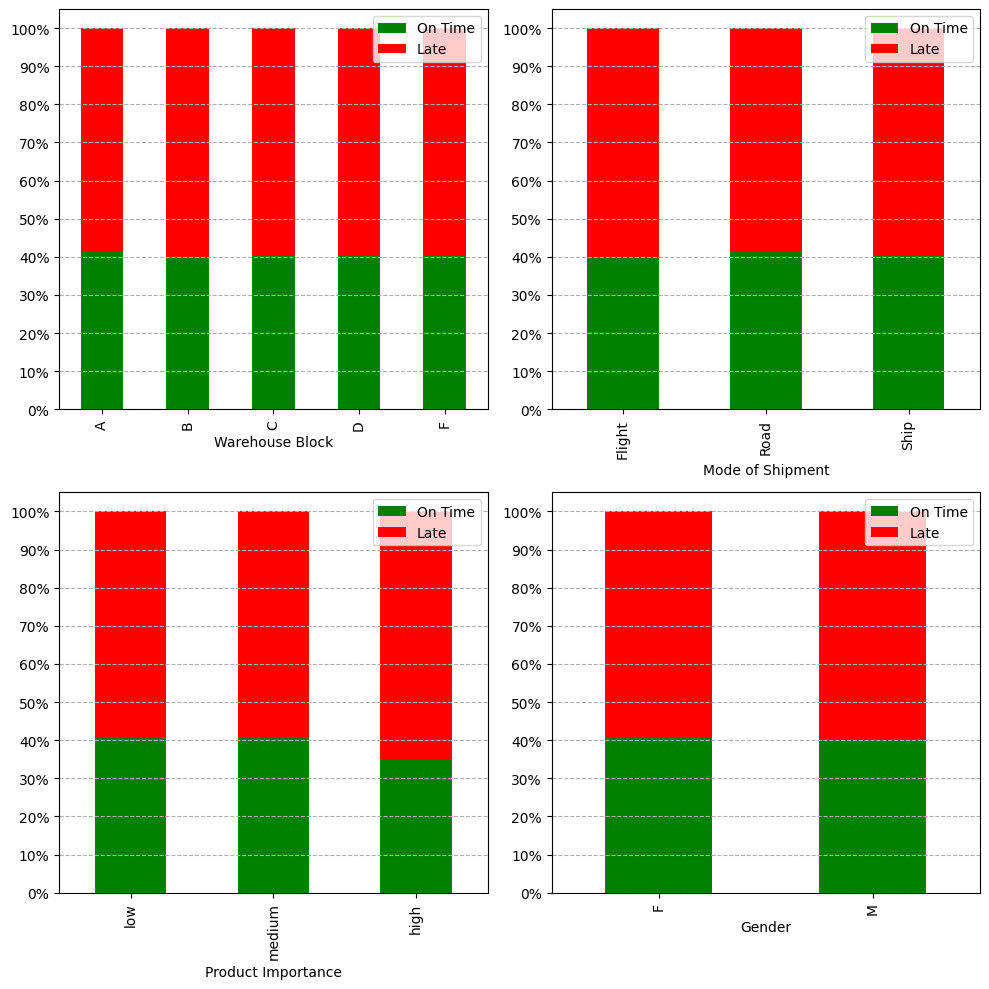

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

normalized_warehouse_block = df.groupby('Warehouse_block')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_warehouse_block.columns = ['Warehouse_block', 'Arrived_Late', 'Percentage']
normalized_warehouse_block = normalized_warehouse_block.pivot_table(values='Percentage', columns='Arrived_Late', index='Warehouse_block')
normalized_warehouse_block.plot(kind='bar', stacked=True, ax=axs[0, 0], color=['green', 'red'])
axs[0, 0].set_xlabel('Warehouse Block')

normalized_mode_shipment = df.groupby('Mode_of_Shipment')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_mode_shipment.columns = ['Mode_of_Shipment', 'Arrived_Late', 'Percentage']
normalized_mode_shipment = normalized_mode_shipment.pivot_table(values='Percentage', columns='Arrived_Late', index='Mode_of_Shipment')
normalized_mode_shipment.plot(kind='bar', stacked=True, ax=axs[0, 1], color=['green', 'red'])
axs[0, 1].set_xlabel('Mode of Shipment')

normalized_product_importance = df.groupby('Product_importance')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_product_importance.columns = ['Product_importance', 'Arrived_Late', 'Percentage']
normalized_product_importance = normalized_product_importance.pivot_table(values='Percentage', columns='Arrived_Late', index='Product_importance').reindex(['low', 'medium', 'high'])
normalized_product_importance.plot(kind='bar', stacked=True, ax=axs[1, 0], color=['green', 'red'])
axs[1, 0].set_xlabel('Product Importance')

normalized_gender = df.groupby('Gender')['Arrived_Late'].value_counts(normalize=True).mul(100).reset_index()
normalized_gender.columns = ['Gender', 'Arrived_Late', 'Percentage']
normalized_gender = normalized_gender.pivot_table(values='Percentage', columns='Arrived_Late', index='Gender')
normalized_gender.plot(kind='bar', stacked=True, ax=axs[1, 1], color=['green', 'red'])
axs[1, 1].set_xlabel('Gender')

yticks = np.arange(0, 101, 10)
label = [str(i)+'%' for i in yticks ]
for a in range(0, 2):
    for b in range(0, 2):
        axs[a, b].set_yticks(yticks, label)
        axs[a, b].grid(axis='y', linestyle='--')
        axs[a, b].legend(['On Time', 'Late'], loc='upper right')

plt.tight_layout()
plt.show()

**Hubungan antara Blok Gudang, Mode Shipment, dan Gender dengan Late Arrival:**
Tidak nampak adanya perbedaan yang signifikan dalam tingkat keterlambatan pengiriman berdasarkan blok gudang, mode pengiriman, atau jenis kelamin (gender). Ini bisa berarti bahwa faktor-faktor ini mungkin tidak memiliki pengaruh yang signifikan terhadap keterlambatan pengiriman.

**Product Importance:**
Pada produk dengan tingkat kepentingan tinggi (High), terlihat bahwa persentase keterlambatan pengiriman lebih besar dibandingkan dengan produk yang memiliki tingkat kepentingan lainnya. Namun, perbedaannya tidak dianggap signifikan.


In [29]:
df.drop(columns=['Discount_offered_bins', 'Weight_bins', 'Cost_of_the_product_bins'], inplace=True)

# Checking Multikolinearitas

## Chi Square Contingency Variabel Independen (Categorical)

In [30]:
def chi_square(column):
    chgrup = df.groupby(column)['Arrived_Late'].value_counts(normalize=True).to_frame()
    chgrup.columns = ['Proportion']
    chpvt = chgrup.reset_index().pivot(columns='Arrived_Late',index=column,values='Proportion')
    display(chpvt*100)
    
    contingency = df.groupby(column)['Arrived_Late'].value_counts().to_frame().reset_index()
    contingency = contingency.pivot(columns='Arrived_Late',index=column,values='count')
    stat, p, dof, expected = chi2_contingency(contingency)
    
    if(p<0.05):
        print(f'\nKolom {column} berkorelasi kuat dengan kolom Arrived Late.\n\n')
    else:
        print(f'\nKolom {column} berkorelasi lemah dengan kolom Arrived Late.\n\n')
        
    print('------------------------------------------------------------------------------')

for cat in cats: 
    chi_square(cat)

Arrived_Late,0,1
Warehouse_block,,
A,41.352973,58.647027
B,39.770867,60.229133
C,40.316421,59.683579
D,40.239913,59.760087
F,40.152755,59.847245



Kolom Warehouse_block berkorelasi lemah dengan kolom Arrived Late.


------------------------------------------------------------------------------


Arrived_Late,0,1
Mode_of_Shipment,,
Flight,39.842431,60.157569
Road,41.193182,58.806818
Ship,40.243902,59.756098



Kolom Mode_of_Shipment berkorelasi lemah dengan kolom Arrived Late.


------------------------------------------------------------------------------


Arrived_Late,0,1
Product_importance,,
high,35.021097,64.978903
low,40.721163,59.278837
medium,40.954985,59.045015



Kolom Product_importance berkorelasi kuat dengan kolom Arrived Late.


------------------------------------------------------------------------------


Arrived_Late,0,1
Gender,,
F,40.559062,59.440938
M,40.099010,59.900990



Kolom Gender berkorelasi lemah dengan kolom Arrived Late.


------------------------------------------------------------------------------


**Dari chi square test, atribut kategorikal yang memiliki pengaruh kuat terhadap Arrived_Late adalah Product_Importance**

## Variance Inflation Factor Variabel Independen (Numerical)

In [31]:
## Define dependent variable
y = df['Arrived_Late']

## Define Indeoendent variable
x = df[['Customer_care_calls','Customer_rating','Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']]

## Add a constant to the independent variables matrix
x = sm.add_constant(x)

## Fit the OLS model
model = sm.OLS(y, x).fit()

In [32]:
## Get variables for which to compute VIF and add intercept term
x = sm.add_constant(df[['Customer_care_calls','Customer_rating','Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']])

## Compute and view VIF
vif = pd.DataFrame()
vif['variables'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif)

             variables        VIF
0                const  59.965283
1  Customer_care_calls   1.259075
2      Customer_rating   1.000308
3  Cost_of_the_Product   1.143080
4      Prior_purchases   1.070394
5     Discount_offered   1.294418
6        Weight_in_gms   1.383040


**Pengecekan Variance Inflation Factor Variabel Independen (numerical) di atas:** Terlihat nilai VIF seluruh variabel bebas di atas nilainya di rentang 1, artinya tidak terdeteksi efek multikolinearitas. Dikarenakan ambang batas VIF adalah 10. Maka dalam contoh Machine Learning Supervised Regresi dapat dilakukan. Namun, untuk tim kami menggunakan Supervised Classification.

# **Additional Insight and Visualization**

In [33]:
Discount_Mean = pd.pivot_table(data=df, index='Customer_rating', columns='Arrived_Late', values='Discount_offered', aggfunc='mean')
Discount_Mean

Arrived_Late,0,1
Customer_rating,,
1,5.536876,19.020564
2,5.659193,19.313433
3,5.412698,17.898305
4,5.690745,18.402149
5,5.425059,18.727411


#### **Analisis**
**Rata-rata diskon** yang diberikan pada setiap tingkat rating pelanggan **('Customer_rating')** tergantung pada apakah pengiriman tepat waktu **('Arrived_Late' = 0)** atau terlambat **('Arrived_Late' = 1):**

**Pengaruh Keterlambatan Terhadap Rata-rata Diskon:** Dapat dilihat bahwa rata-rata diskon cenderung lebih tinggi untuk pengiriman yang terlambat (Arrived_Late = 1), dibandingkan dengan pengiriman tepat waktu (Arrived_Late = 0) untuk setiap tingkat rating pelanggan. Ini bisa menunjukkan bahwa perusahaan memberikan diskon yang lebih besar sebagai insentif atau kompensasi atas keterlambatan dalam pengiriman.

**Perbedaan Rata-rata Diskon antar Tingkat Rating:** Terdapat variasi dalam rata-rata diskon antar tingkat rating pelanggan. Misalnya, pelanggan dengan rating 2 memiliki rata-rata diskon yang sedikit lebih tinggi dibandingkan pelanggan dengan rating lainnya.

**Stabilitas Rata-rata Diskon:** Dalam setiap tingkat rating, rata-rata diskon tampak cukup konsisten antara pengiriman tepat waktu dan terlambat. Ini menunjukkan bahwa strategi penentuan diskon mungkin tidak terlalu bergantung pada keterlambatan pengiriman.



#### **Kesimpulan:**
Untuk pengiriman terlambat lebih banyak mendapatkan diskon dan ini cukup berdampak pada customer rating, walaupun masih ada yang memberikan rating kurang memuaskan.

#### **Business recommendation:**
- Jika tujuannya adalah untuk mengurangi diskon yang diberikan pada pengiriman terlambat, perusahaan dapat mengevaluasi dan meningkatkan efisiensi rantai pasokan atau mengimplementasikan strategi pengiriman yang lebih andal.
- Atau justru dengan cara untuk menjaga customer rating tetap tinggi adalah dengan memberikan diskon ketika pengiriman tersebut terlambat.

In [34]:
new_df = df[(df['Weight_in_gms']>2000) & (df['Weight_in_gms']<4000)]

Text(0, 0.5, 'Total')

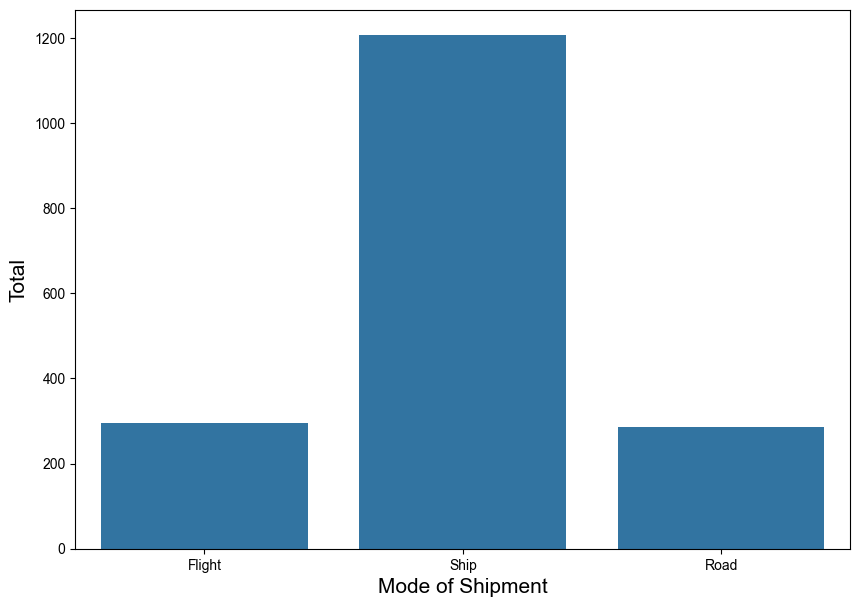

In [35]:
plt.figure(figsize=(10,7))
chart = sns.countplot(data=new_df, x='Mode_of_Shipment')

sns.set(font_scale= 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')

chart.set_xlabel("Mode of Shipment", fontsize = 15)
chart.set_ylabel("Total", fontsize = 15)

Mode ship menjadi mode yang paling tinggi penggunaannya dan menyebabkan keterlambatan akibat berat 2000-4000 gram.

Text(0, 0.5, 'Total')

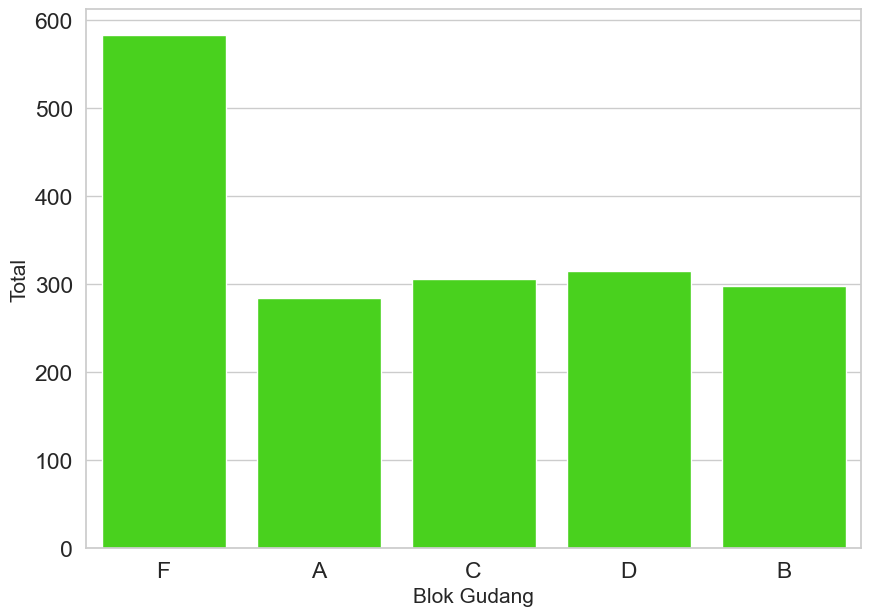

In [36]:
plt.figure(figsize=(10,7))
chart = sns.countplot(data=new_df, x='Warehouse_block')

sns.set(font_scale= 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')

chart.set_xlabel("Blok Gudang", fontsize = 15)
chart.set_ylabel("Total", fontsize = 15)

Warehouse F menjadi gudang yang paling banyak digunakan untuk weight 2000-4000 gram.

In [37]:
pivot = pd.pivot_table(
data = new_df,
index='Mode_of_Shipment',
columns='Warehouse_block',
aggfunc={'Warehouse_block':['count']})
pivot = pivot.reset_index()
column = ['Shipment','A','B','C','D','F']
pivot.columns = column
pivot

,Shipment,A,B,C,D,F
0,Flight,54,48,48,55,90
1,Road,42,48,46,56,93
2,Ship,188,202,212,204,400


Mode pengiriman Ship cenderung memiliki unit warehouse blok lebih banyak dibandingkan unit lainnya, sekitar >50% dibandingkan unit warehouse di Flight & Road.

In [38]:
df_melted = pd.melt(id_vars='Shipment',frame=pivot)
df_melted

,Shipment,variable,value
0,Flight,A,54
1,Road,A,42
2,Ship,A,188
3,Flight,B,48
4,Road,B,48
5,Ship,B,202
6,Flight,C,48
7,Road,C,46
8,Ship,C,212
9,Flight,D,55


Text(0, 0.5, 'Total')

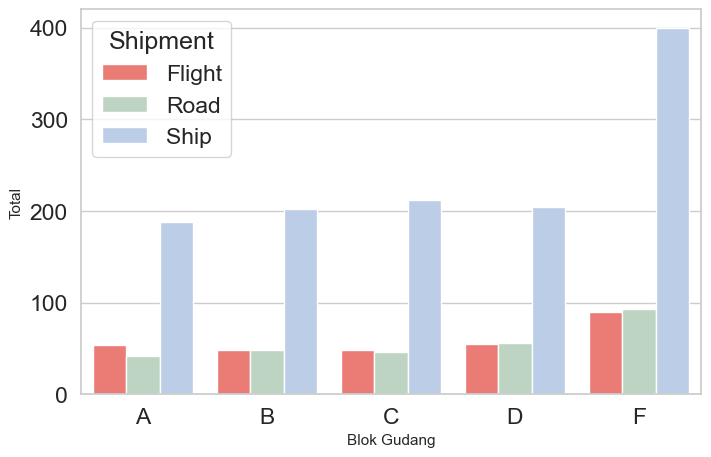

In [39]:
plt.figure(figsize=(8,5))
chart = sns.barplot(x='variable', y='value',hue='Shipment', data=df_melted, palette={'Flight':'#FF6961', 'Road':'#B8D8BE', 'Ship':'#B4CBF0'})
sns.set_style('whitegrid')

chart.set_xlabel("Blok Gudang", fontsize = 11)
chart.set_ylabel("Total", fontsize = 11)

#### **Insight:**
Di warehouse F dan mode ship paling banyak digunakan.

#### **Business Recommendation:**
Memberikan rekomendasi untuk melakukan pengiriman menggunakan mode road untuk jarak pendek dan flight untuk jarak jauh pada pengiriman dengan berat 2000 - 4000 dan melakukan persebaran pada masing-masing warehouse dalam menyimpan barang sehingga tidak terjadi penumpukan pada satu warehouse

### **Metrics Evaluation yang Akan Digunakan**
Dalam training machine learning model, kami memilih menggunakan **F1-Score** karena dianggap lebih seimbang dan tidak menyebabkan kebingungan pada model dalam mempelajari hasilnya.

Sementara untuk rekomendasi bisnis, kita akan menggunakan **Precision** dalam memberikan prediksi dampak bisnisnya. 

### **Business Recommendation**

- Monitoring untuk pemberian diskon >10% agar tidak mempengaruhi volume order, tujuannya agar tidak berdampak pada keterlambatan pengiriman. 
 
- Memberikan diskon tambahan untuk customer, agar penilaian ratingnya meningkat. Selain itu, melakukan survei kepuasan dan mengumpulkan feedback ke customer agar mengetahui root cause kendala dapat ditangani dengan baik.

- Memberikan rekomendasi untuk melakukan pengiriman menggunakan mode road untuk jarak pendek dan flight untuk jarak jauh pada pengiriman dengan berat 2000-4000 gram, dan melakukan persebaran pada masing-masing warehouse dalam menyimpan barang sehingga tidak terjadi penumpukan pada satu warehouse.

# Handle Missing Value, Duplicated Data, dan Outliers

Pada tahap ini, kami tidak menghandle Missing Value, Duplicated Data dan Outliers. Dikarenakan tidak ada missing value dan tidak ada duplicated data, meskipun memiliki outliers pada feature Discount_offered dan Prior_purchase namun masih wajar, sehingga dapat diabaikan.

# Handling Class Imbalance

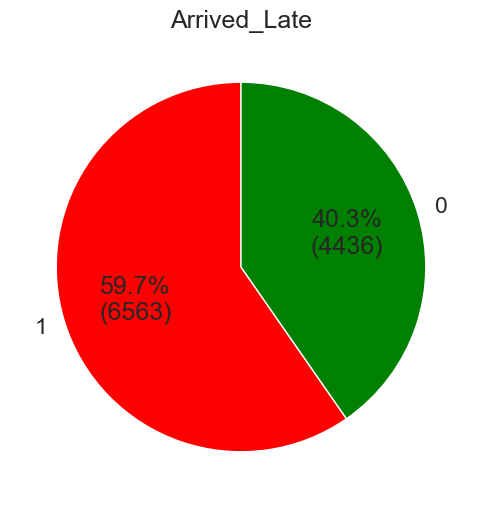

In [40]:
total_count = len(df['Arrived_Late'])
category_counts = df['Arrived_Late'].value_counts()
percentage = (category_counts / total_count) * 100

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentage, labels=category_counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * total_count / 100), startangle=90, colors=['red', 'green'])
plt.title('Arrived_Late')
plt.show()

Berdasarkan hasil analisis data, perbandingan antara pengiriman yang tepat waktu (40%: 4463) dan yang tidak tepat waktu (60%: 6563) menunjukkan bahwa distribusi kelas tidak memiliki class imbalance yang signifikan. 

Oleh karena itu, tidak diperlukan tindakan penanganan class imbalance dalam pemodelan machine learning, karena kedua kelas memiliki persentase yang relatif seimbang.

# Feature Extraction

In [41]:
df['weight_between_2kg_and_4kg'] = np.where(((df['Weight_in_gms'] > 2000) & (df['Weight_in_gms'] < 4000)), 1, 0)
df['discount_>10'] = np.where((df['Discount_offered']>10), 1, 0)

# Feature Selection

In [42]:
dropped_cols = ['Customer_care_calls', 'Customer_rating', 'Gender', 'Discount_offered', 'Weight_in_gms']

df.drop(columns=dropped_cols, inplace=True)

# Splitting Dataset

In [43]:
X = df.drop(columns="Arrived_Late")
y = df.Arrived_Late

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8799, 7), (2200, 7), (8799,), (2200,))

# Building Pipeline

In [44]:
product_importance_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['low', 'medium', 'high']]))
])

nominal_cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first'))
]) 

numerical_pipeline = Pipeline([
    ('standard', StandardScaler())
] )

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, ["Cost_of_the_Product"]),
    ('product_importance', product_importance_pipeline, ["Product_importance"]),
    ('nominal', nominal_cat_pipeline, ['Warehouse_block', 'Mode_of_Shipment']),
    ('passthrough', 'passthrough', ['Prior_purchases', 'weight_between_2kg_and_4kg', 'discount_>10'])
])

# Support Vector Classifier

In [45]:
from sklearn.svm import SVC

In [46]:
print(f"Hyperparameter Tuning\n{rsp.svm_params}")

Hyperparameter Tuning
{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'), 'algo__C': Real(low=-3, high=3, prior='log-uniform')}


In [47]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train, y_train)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test, y_test)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\mufad\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Hyperparameter Terbaik: 
{'algo__C': 0.008632008168602547, 'algo__gamma': 0.00862913219007186}

Training F1-Score : 0.7383184361601628
Validation F1-Score : 0.740966357339061
Testing F1-Score : 0.7384259259259259



# XGBoost

In [48]:
from xgboost import XGBClassifier

In [49]:
print(f"Hyperparameter Tuning\n{rsp.xgb_params}")

Hyperparameter Tuning
{'algo__max_depth': Integer(low=1, high=10), 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'), 'algo__n_estimators': Integer(low=100, high=200), 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'), 'algo__gamma': Integer(low=1, high=10), 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'), 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'), 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}


In [50]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train, y_train)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test, y_test)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Hyperparameter Terbaik: 
{'algo__colsample_bytree': 0.22858013612974673, 'algo__gamma': 3, 'algo__learning_rate': 0.010994335574766196, 'algo__max_depth': 2, 'algo__n_estimators': 187, 'algo__reg_alpha': 2.1368329072358785, 'algo__reg_lambda': 0.007068974950624601, 'algo__subsample': 0.3909124836035503}

Training F1-Score : 0.7473841554559043
Validation F1-Score : 0.746467795784446
Testing F1-Score : 0.7475092513521207



# K - Nearest Neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
print(f"Hyperparameter Tuning\n{rsp.knn_params}")

Hyperparameter Tuning
{'algo__n_neighbors': Integer(low=1, high=40), 'algo__weights': ['uniform', 'distance'], 'algo__p': Real(low=1, high=2, prior='uniform')}


In [53]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = RandomizedSearchCV(pipeline, rsp.knn_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train, y_train)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test, y_test)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Hyperparameter Terbaik: 
{'algo__n_neighbors': 27, 'algo__p': 1.6118528947223796, 'algo__weights': 'distance'}

Training F1-Score : 0.946044946044946
Validation F1-Score : 0.6989384388899228
Testing F1-Score : 0.6799046862589356



# GridSearcdCV

In [54]:
print(f"Hyperparameter Tuning\n{gsp.svm_params}")

Hyperparameter Tuning
{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


In [55]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train, y_train)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test, y_test)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\mufad\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Hyperparameter Terbaik: 
{'algo__C': 0.00428403710419697, 'algo__gamma': 0.005181237417045342}

Training F1-Score : 0.7465936125729941
Validation F1-Score : 0.74176964188085
Testing F1-Score : 0.744039069232979



In [56]:
print(f"Hyperparameter Tuning\n{gsp.xgb_params}")

Hyperparameter Tuning
{'algo__max_depth': [3, 6, 10], 'algo__colsample_bytree': [0.4, 0.6, 0.8], 'algo__n_estimators': [100, 150, 200], 'algo__subsample': [0.4, 0.6, 0.8], 'algo__gamma': [1, 5, 10], 'algo__learning_rate': [0.01, 0.1, 1], 'algo__reg_alpha': [0.01, 0.1, 10], 'algo__reg_lambda': [0.01, 0.1, 10]}


In [57]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.xgb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train, y_train)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test, y_test)}
""")

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits

Hyperparameter Terbaik: 
{'algo__colsample_bytree': 0.8, 'algo__gamma': 1, 'algo__learning_rate': 0.01, 'algo__max_depth': 6, 'algo__n_estimators': 100, 'algo__reg_alpha': 10, 'algo__reg_lambda': 10, 'algo__subsample': 0.6}

Training F1-Score : 0.7473841554559043
Validation F1-Score : 0.7474720276678125
Testing F1-Score : 0.7475092513521207



# With PCA

In [58]:
# Handling Categorical Data

product_importance_mapping = {'low' : 0,
                              'medium' : 1,
                              'high' : 2}

gender_mapping = {'F' : 0,
                  'M' : 1}

data['Product_importance'] = data['Product_importance'].map(product_importance_mapping)

data['Gender'] = data['Gender'].map(gender_mapping)

data = pd.get_dummies(data, columns=['Warehouse_block', 'Mode_of_Shipment'], dtype='int')

In [59]:
X_data = data.drop(columns='Arrived_Late')
y_data = data.Arrived_Late

In [60]:
# Transformation

num_feats = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Weight_in_gms']
feats_with_outliers = ['Prior_purchases', 'Discount_offered']

std_scaler = StandardScaler()
robust_scaler = RobustScaler()

std_scaler.fit(X_data[num_feats])
robust_scaler.fit(X_data[feats_with_outliers])

X_data[num_feats] = std_scaler.transform(X_data[num_feats])
X_data[feats_with_outliers] = robust_scaler.transform(X_data[feats_with_outliers])

In [61]:
# PCA

pca = PCA(n_components=2)
pca.fit(X_data)
X_pca = pca.transform(X_data)
X_pca = pd.DataFrame(X_pca, columns=['pc1', 'pc2'])

### Visualization

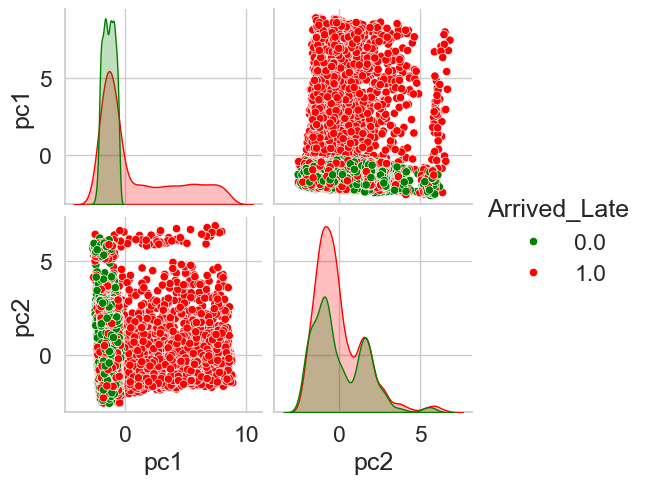

In [62]:
data_pca = X_pca.copy()
data_pca['Arrived_Late'] = y_data

sns.pairplot(data=data_pca, hue='Arrived_Late', palette={0:'green', 1:'red'})

In [63]:
# Splitting Data

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)
X_train_pca.shape, X_test_pca.shape, y_train_pca.shape, y_test_pca.shape

((8799, 2), (2200, 2), (8799,), (2200,))

In [64]:
# Training Model

pipeline = Pipeline([('algo', SVC(max_iter=500))])
model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train_pca, y_train_pca)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train_pca, y_train_pca)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test_pca, y_test_pca)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\mufad\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Hyperparameter Terbaik: 
{'algo__C': 0.002231010801867923, 'algo__gamma': 157.41890047456675}

Training F1-Score : 0.7465151515151515
Validation F1-Score : 0.7388730268958045
Testing F1-Score : 0.7379056950398041



In [65]:
# Training Model

pipeline = Pipeline([('algo', XGBClassifier(n_jobs=1, random_state=42))])
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train_pca, y_train_pca)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train_pca, y_train_pca)}
Validation F1-Score : {model.best_score_}pip
Testing F1-Score : {model.score(X_test_pca, y_test_pca)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Hyperparameter Terbaik: 
{'algo__colsample_bytree': 0.7149371669429124, 'algo__gamma': 8, 'algo__learning_rate': 0.011715937392307056, 'algo__max_depth': 1, 'algo__n_estimators': 135, 'algo__reg_alpha': 0.005357280069601829, 'algo__reg_lambda': 1.0506199451597058, 'algo__subsample': 0.5125779372456224}

Training F1-Score : 0.7418694564475778
Validation F1-Score : 0.7418236481977679
Testing F1-Score : 0.7403551745254133



In [66]:
# Training Model

pipeline = Pipeline([('algo', KNeighborsClassifier())])
model = RandomizedSearchCV(pipeline, rsp.knn_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train_pca, y_train_pca)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train_pca, y_train_pca)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test_pca, y_test_pca)}
""")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Hyperparameter Terbaik: 
{'algo__n_neighbors': 2, 'algo__p': 1.7219987722668249, 'algo__weights': 'distance'}

Training F1-Score : 1.0
Validation F1-Score : 0.6899991467561486
Testing F1-Score : 0.694359756097561



## Using GridSearchCV

In [67]:
#Training Model

pipeline = Pipeline([('algo', SVC(max_iter=500))])
model = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train_pca, y_train_pca)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train_pca, y_train_pca)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test_pca, y_test_pca)}
""")

Fitting 5 folds for each of 49 candidates, totalling 245 fits


c:\Users\mufad\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Hyperparameter Terbaik: 
{'algo__C': 0.001, 'algo__gamma': 1000.0}

Training F1-Score : 0.7655617219139043
Validation F1-Score : 0.7383420414521699
Testing F1-Score : 0.743505524037026



In [68]:
#Training Model

pipeline = Pipeline([('algo', XGBClassifier(n_jobs=1, random_state=42))])
model = GridSearchCV(pipeline, gsp.xgb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train_pca, y_train_pca)

print(f"""
Hyperparameter Terbaik: 
{model.best_params_}

Training F1-Score : {model.score(X_train_pca, y_train_pca)}
Validation F1-Score : {model.best_score_}
Testing F1-Score : {model.score(X_test_pca, y_test_pca)}
""")

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits

Hyperparameter Terbaik: 
{'algo__colsample_bytree': 0.4, 'algo__gamma': 1, 'algo__learning_rate': 0.01, 'algo__max_depth': 3, 'algo__n_estimators': 100, 'algo__reg_alpha': 10, 'algo__reg_lambda': 10, 'algo__subsample': 0.4}

Training F1-Score : 0.7473841554559043
Validation F1-Score : 0.7473841706056664
Testing F1-Score : 0.7475092513521207



#### Reference 1 : https://lifewithdata.com/2023/06/04/how-to-calculate-variance-inflation-factor-vif-in-python/
#### Reference 2 : https://statorials.org/id/cara-menghitung-vive-dengan-python/
#### Reference 3 : https://www.kaggle.com/code/ridhoaryo/sba-loan-approval-model